|--------------------------
|    BUSINESS UNDERSTANDING
|--------------------------

CÉL

A feladat elsődleges célja a marketing költségek csökkentése azonos várható bevétel mellett vagy 
a marketing költség hatékonyabb felhasználása, azaz bevételnövelés. Ezt a célt az ügyfelek viselkedésének 
előrejelzése alapján igyekszünk elérni, megcélozva azokat az individuumokat egy későbbi kampányban, akik a legvalószínűbb, 
hogy igénylik a termed deposit szolgáltatást. A cél technikai szempontból tehát egy olyan model megalkotása,
amely adott inputok alapján képes előre jelezni az ügyfelek várható viselkedését, ami lehetővé teszi a marketing
tevékenység célzott alkalmazását.

|-----------------------
|    IMPORT LIBRARIES
|-----------------------

In [108]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import itertools
#%matplotlib inline
get_ipython().magic('matplotlib inline')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import statsmodels.formula.api as smf
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

|-----------------------
|    LOAD DATA
|-----------------------

In [56]:
#Importing and displaying data
data = pd.read_csv("otp_datascientist_beadando.csv", delimiter=";",header='infer')
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


Az adathalmaz 16 predictort, ezek közül 9 minőségi és 7 mennyiségi predictor és egy output, dependent változót ('y') tartalmaz.

|------------------------------------------
|    EXPLORATION
|------------------------------------------

In [57]:
print(data.shape)
print(data[data.duplicated(subset=None, keep='first')].shape)
print(data.isnull().sum())
data[data.isnull().any(axis=1)]

(45211, 17)
(0, 17)
age          0
job          0
marital      1
education    0
default      0
balance      0
housing      1
loan         0
contact      1
day          0
month        2
duration     0
campaign     0
pdays        0
previous     0
poutcome     1
y            3
dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
31,49,management,married,tertiary,no,378,NaN,no,unknown,5,may,230,1,-1,0,unknown,no
35,57,technician,divorced,secondary,no,63,yes,no,unknown,5,NaN,242,1,-1,0,unknown,no
31613,46,admin.,single,secondary,no,1070,yes,no,cellular,6,apr,194,2,-1,0,NaN,no
31632,36,blue-collar,married,secondary,no,2454,yes,no,cellular,6,apr,1859,1,-1,0,unknown,NaN
31648,33,blue-collar,married,secondary,no,1101,yes,no,cellular,6,apr,399,2,-1,0,unknown,NaN
31678,42,blue-collar,married,secondary,no,349,yes,no,NaN,7,apr,226,2,-1,0,unknown,no
31701,36,services,NaN,secondary,no,3740,yes,no,cellular,7,apr,254,1,-1,0,unknown,no
31764,36,blue-collar,single,secondary,no,1822,yes,no,cellular,8,NaN,952,1,323,1,other,yes
45044,35,management,married,secondary,no,724,yes,no,cellular,18,oct,102,3,96,3,success,NaN


Több féle lehetőség is van hiányzó adatok pótlására például regresszióval, átlaggal, leggyakoribb értékkel vagy forward-fill módszerrel. Ezek jellemzően predictor értékek feltöltésére használhatók, míg a dependent variable ilyen módon nem igazán határozható meg. Minthogy az adathalmaz 45211 sort tartalmaz és a fenti sorok értékei nem különösebben kiugróak, ezért az adathalmazból eltávolíthajuk ezeket a sorokat anélkül, hogy statisztikai torzítást vinnénk a rendszerbe.

In [58]:
data.dropna(axis=0, how='any', inplace=True)
data.shape

(45202, 17)

In [59]:
data.describe(include=["object"])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45202,45202,45202,45202,45202,45202,45202,45202,45202,45202
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9728,27208,23194,44387,25121,37958,29278,13764,36952,39914


A minőségi változók a leiratnak megfelelő számú értéket vesznek fel. Érdemes észre venni, hogy a predictorok közül a 'default', 'loan', 'poutcome' valamint a dependent variable skewed. Ez egyes modelezési technikáknál extra odefigyelést igényelhet. 

Elgondolkoztató, hogy a 'contact' predictor vajon használható-e, amennyiben ez nem általános, hanem a legutóbbi hívásra vonatkozik, aminek a kimenetelét szeretnénk megjósolni, akkor ez data leakage volna, tehát a business goal eléréséhez segítő modelhez alkalmatlan volna.

In [60]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45202.000000,45202.000000,45202.000000,45202.000000,45202.000000,45202.000000,45202.00000
mean,40.936175,1362.284434,15.810053,258.115858,2.764081,40.196717,0.58035
std,10.619276,3045.027882,8.324412,257.420503,3.098267,100.128222,2.30363
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.00000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.00000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.00000
75%,48.000000,1427.750000,21.000000,319.000000,3.000000,-1.000000,0.00000
max,95.000000,102127.000000,40.000000,4918.000000,63.000000,871.000000,275.00000


A mennyiségi változók szintén a vártnak megfelelően viselkednek, habár az 'age' predictor 95 valamint a 'previous' 275 elég kiugróan hat, valamint természetesen nincs 40. nap egyetlen hónapban sem. A kiugró adatok (outliers) jelentősen torzíthatják egyes esetekben a regresszión alapuló modelleket, eltávolításukkal statisztikai szempontból relevánsabb modelt kaphatunk, azonban csupán statisztikai mérőszámokra (hat, leverage, studentized residual) hivatkozva veszélyes eltávolítani ezeket az adatpontokat, hiszen ezzel akár a valódi eloszlást jócskán eltorzíthatjuk.

In [61]:
data[data['day']==40]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
31568,39,management,married,secondary,no,517,yes,no,cellular,40,apr,240,1,136,5,failure,no
45029,40,housemaid,married,primary,no,979,no,no,cellular,40,oct,106,4,-1,0,unknown,no
45179,34,technician,married,secondary,no,1026,no,no,cellular,40,nov,319,1,100,6,failure,no


Mind áprilisban, októberben és novemberben van 30. napja a hónapnak, ezért kézenfekvőnek tűnik a féltételezés, hogy az adatbevitel során az első számjegyet elütöttéték. Élve ezzel a feltételezéssel az adatokat korrigáljuk 40-ről 30-ra.

In [62]:
data.loc[data['day']==40,'day'] = 30

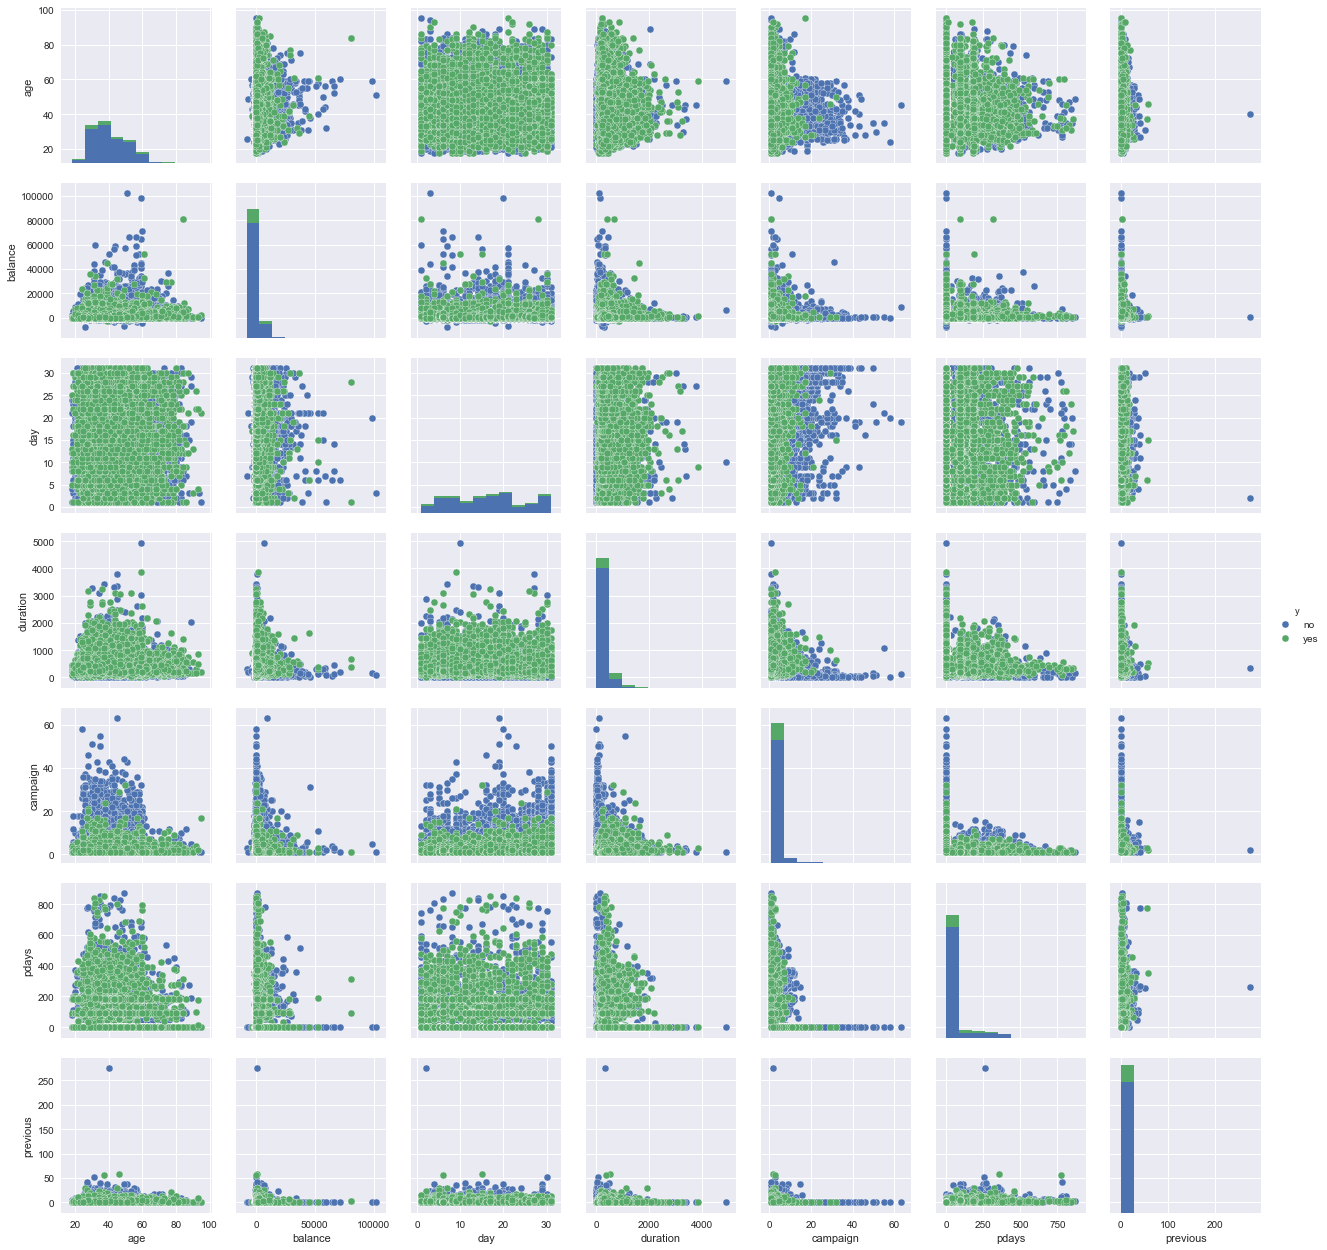

In [63]:
sns.pairplot(data, hue='y')

A fenti ábrán láthatjuk, hogy a hívásokat valóban randomizált módon készítették, tehát egyetlen életkor vagy munka sincs túlzott mértékben reprezentálva az adathalmazban, sem pedig a hónapokon belüli napok nincsenek különösebben hangsúlyozva. 
Látható, hogy a 'previous' predictor valóban tartalmaz egy outliert. Minthogy no gyakoribb a dependent variable értékeiben és kellően nagy adathalmazzal dolgozunk, ezért talán indokoltnak tarthatjuk ennek az outliernek a kiemelését az adathalmazból.

In [64]:
data.drop(data.previous.idxmax(), inplace=True)

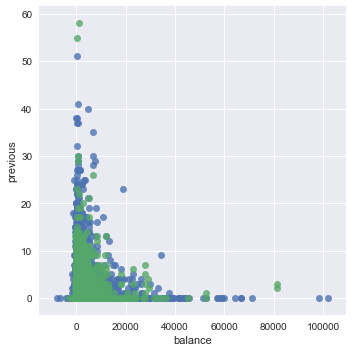

In [65]:
# check how the scatter improved by removing outlier
sns.lmplot( x="balance", y="previous", data=data, fit_reg=False, hue='y', legend=False)

In [66]:
def get_ratio(df,x_axis,y_axis,condition):
    """Return x and y for pointplot of dataframe df from column x_axis, 
       conditioned by y_axis as ratio based on condition value."""
    
    success = df[df[y_axis]==condition]
    numerator = success.groupby(x_axis)[y_axis].count()
    denominator = df.groupby(x_axis)[y_axis].count()
    y_temp = numerator/denominator
    x_temp = y_temp.index[:]

    return x_temp,y_temp

In [67]:
bins = [0,10,100,200,300,400,500,600,700,800,900,1000,1500,5000]
names = ['0-10','10-100','100-200','200-300','300-400','400-500','500-600',
        '600-700','700-800','800-900','900-1000','1000-1500','1500-5000']
data['duration_bins'] = pd.cut(data.duration, bins, labels=names)

Text(0.5,0,'Duration')

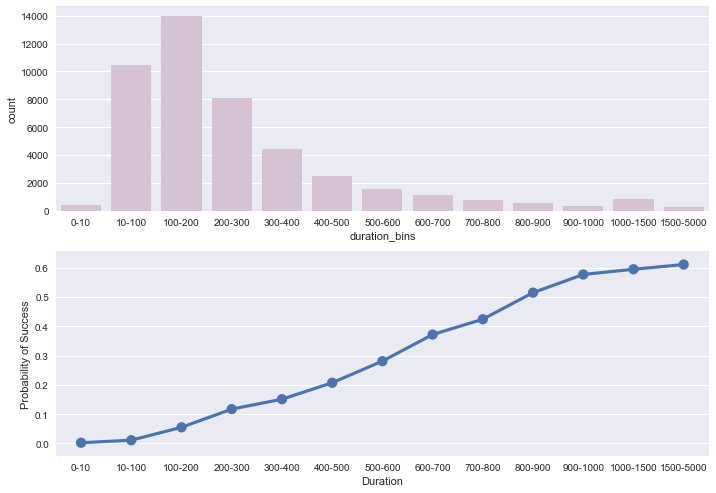

In [68]:
a4_dims = (11.7, 8.27)
x_temp, y_temp = get_ratio(data,'duration_bins','y','yes')

sns.set(font_scale=1)
f, (ax1, ax2) = plt.subplots(2, figsize = a4_dims)
sns.countplot(data['duration_bins'], color="thistle", ax=ax1)
sns.pointplot(x=x_temp,y=y_temp,ax=ax2)
ax2.set_ylabel('Probability of Success')
ax2.set_xlabel('Duration')

Látható a fenti ábra pár alapján, hogy csaknem lineáris összefüggés van a szolgáltatás igénylése és a telefonhívás hosszúsága között. Alaposabban fontolóra véve érthető, hiszen az igénylés során több időt vesz igénybe, hogy a paramétereit a szolgáltatásnak egyeztessék az felek, azonban ez magával vonja azt a konklúziót, hogy ez a változó nem hordoz hasznos információt az üzleti cél tekintetében, hiszen nem tudjuk előre, hogy mennyi időt vesz majd egy hívás igénybe, mielőtt a hívást megtennénk. Ezt a változót tehát el kell hagynunk az adathalmazból.

In [69]:
data.drop(labels=['duration_bins','duration'], axis=1, inplace=True)
data.head().transpose()

,0,1,2,3,4
age,58,44,33,47,33
job,management,technician,entrepreneur,blue-collar,unknown
marital,married,single,married,married,single
education,tertiary,secondary,secondary,unknown,unknown
default,no,no,no,no,no
balance,2143,29,2,1506,1
housing,yes,yes,yes,yes,no
loan,no,no,yes,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [70]:
print(data.corr())

               age   balance       day  campaign     pdays  previous
age       1.000000  0.097819 -0.009141  0.004771 -0.023712  0.001862
balance   0.097819  1.000000  0.004461 -0.014576  0.003441  0.020992
day      -0.009141  0.004461  1.000000  0.162354 -0.092924 -0.056926
campaign  0.004771 -0.014576  0.162354  1.000000 -0.088624 -0.038903
pdays    -0.023712  0.003441 -0.092924 -0.088624  1.000000  0.542113
previous  0.001862  0.020992 -0.056926 -0.038903  0.542113  1.000000


Egyetlen érték sincs közel a pozitív vagy negatív korrelációt indikáló értékhez, ezért multicolinearity talán nem probléma az adathalmazban. Azért nem zárhatjuk ki teljesen, hiszen magasabb fokú összefüggés is lehet esetleg változók között, amelyet a korreláció mérőszáma nem tud megfelelően reprezentálni. Általánosan azonban mondhatjuk, hogy az adathalmaz ebből a szempontból megfelel regresszió analízis kritériumoknak.

A kvantitatív változók után a kvalitatív változókról is fontos képet alkotni.

In [71]:
categorical_features = data.select_dtypes(include=[object])

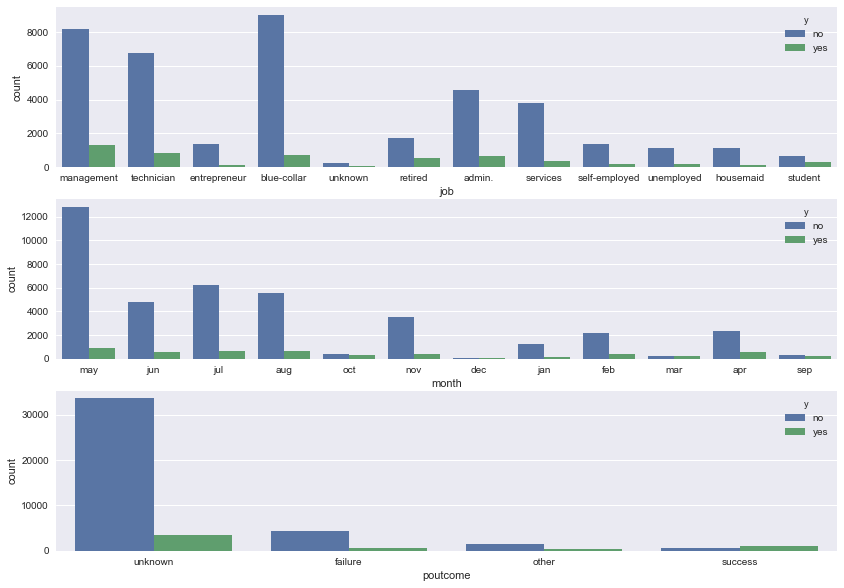

In [72]:
dims = (14, 10)
f, (ax1, ax2, ax3) = plt.subplots(3, figsize = dims)
sns.countplot(x='job', hue='y', data=categorical_features, ax=ax1)
sns.countplot(x='month', hue='y', data=categorical_features, ax=ax2)
sns.countplot(x='poutcome', hue='y', data=categorical_features, ax=ax3)

A fenti ábrán látható, hogy nem minden kategóriában egyenlő számú hívást bonyolítottak, ez különösen a március, szempember, október, december hónapokra igaz. Tehát esetleg az ilyen változók csoportosítása hasznos lehet a tanuló algoritmus szempontjából.
Érdemes megfigyelni, hogy a korábbi marketing kampányokban érdeklődő ügyfelek közül többen voltak, akik igényelték a szolgáltatást mint, akik nem. Ez talán az egyetlen olyan indikátor ahol a feliratkozóknak nagyobb az aránya, mint azoknak, akik elutasították a megkeresést.

|------------------------------------
|    GROUPING, ENCODING, NORMALIZING
|------------------------------------

In [73]:
bins = [17,30,40,50,60,95]
names = ['18-30','31-40','41-50','51-60','61-95']
data['age_bins'] = pd.cut(data.age, bins, labels=names)

bins = [-9000,-5000,-4000,-1000,-500,0,500,1000,2000,3000,4000,5000,10000,20000,40000,103000]
names = ['-9000,-5000','-5000,-4000','-4000,-1000','-1000,-500','-500,0','0,500','500,1000',
         '1000,2000','2000,3000','3000,4000','4000,5000','5000,10000','10000,20000',
         '20000,40000','40000,103000']
data['balance_bins'] = pd.cut(data.balance, bins, labels=names)

In [74]:
lb_make = LabelEncoder()
data['age_bins_code'] = lb_make.fit_transform(data['age_bins'])
#data[['age_bins', 'age_bins_code']].head(5)

In [75]:
lb_make = LabelEncoder()
data["balance_bins_code"] = lb_make.fit_transform(data["balance_bins"])
#data[["balance_bins", "balance_bins_code"]].head(5)

In [76]:
lb_make = LabelEncoder()
data["y_code"] = lb_make.fit_transform(data["y"])
#data[["balance_bins", "balance_bins_code"]].head(5)

In [77]:
# give ID
data['IDcol'] = np.linspace(1, data.shape[0], data.shape[0], dtype=int)

In [78]:
categorical_features = data.select_dtypes(include=[object]).drop('y', axis = 1)
categorical_features_expanded = pd.get_dummies(categorical_features)

In [79]:
numerical_features = data.drop(categorical_features.columns, axis = 1)
id_out = numerical_features[['y','y_code','IDcol']]
numerical_features = numerical_features.drop(['y', 'y_code', 'IDcol', 'balance_bins', 'age_bins'], axis = 1) 

# normalize
num_mean = numerical_features.mean()
num_std = numerical_features.std()
numerical_features = (numerical_features-num_mean.transpose())/num_std

In [80]:
data_w = pd.concat([id_out, numerical_features, categorical_features_expanded], axis = 1)

In [81]:
data_w.columns

Index(['y', 'y_code', 'IDcol', 'age', 'balance', 'day', 'campaign', 'pdays',
       'previous', 'age_bins_code', 'balance_bins_code', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

Text(0.5,0,'Day')

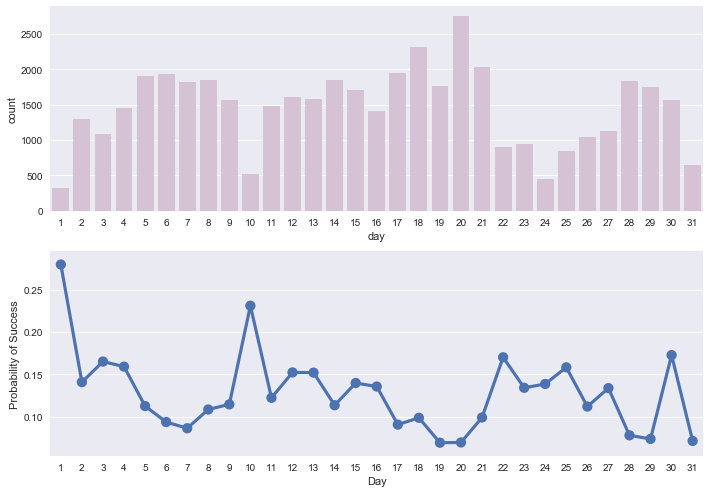

In [82]:
a4_dims = (11.7, 8.27)
x_temp, y_temp = get_ratio(data,'day','y','yes')

f, (ax1, ax2) = plt.subplots(2, figsize = a4_dims)
sns.countplot(data['day'], color="thistle", ax=ax1)
sns.pointplot(x=x_temp,y=y_temp,ax=ax2)
ax2.set_ylabel('Probability of Success')
ax2.set_xlabel('Day')

Text(0.5,0,'Age')

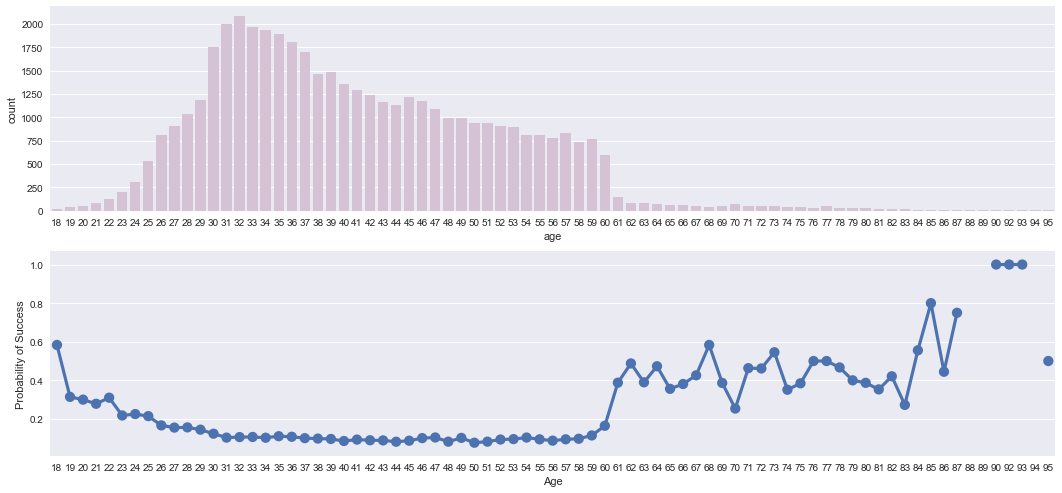

In [83]:
sns.set(font_scale=1)
a4_dims = (18, 8.27)
x_temp, y_temp = get_ratio(data,'age','y','yes')

f, (ax1, ax2) = plt.subplots(2, figsize=a4_dims)
sns.countplot(data['age'], color="thistle", ax=ax1);
sns.pointplot(x=x_temp, y=y_temp, ax=ax2)
ax2.set_ylabel('Probability of Success')
ax2.set_xlabel('Age')

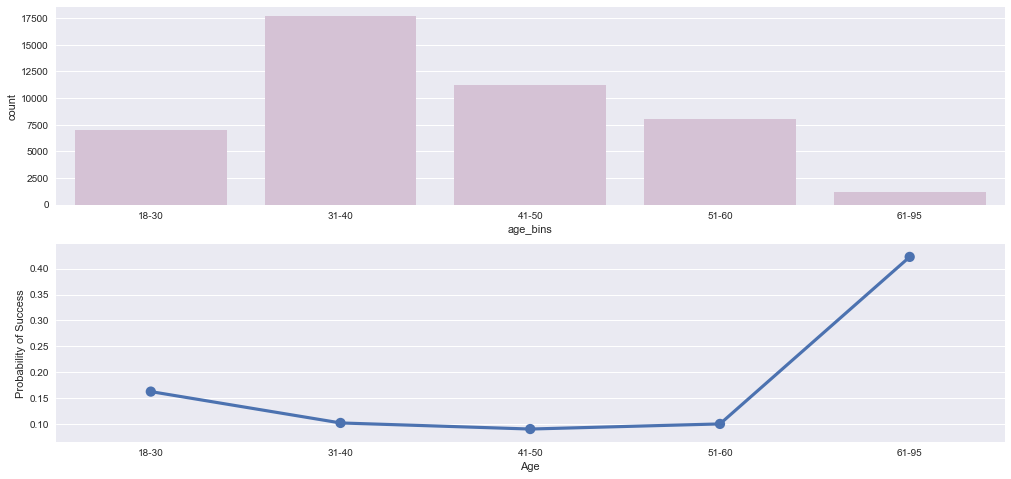

In [84]:
dims = (17, 8)
x_temp, y_temp = get_ratio(data,'age_bins','y','yes')

f, (ax1, ax2) = plt.subplots(2, figsize = dims)
sns.countplot(data['age_bins'], color="thistle", ax=ax1)
sns.pointplot(x=x_temp,y=y_temp,ax=ax2,font_scale=45)
ax2.set_ylabel('Probability of Success')
ax2.set_xlabel('Age')
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

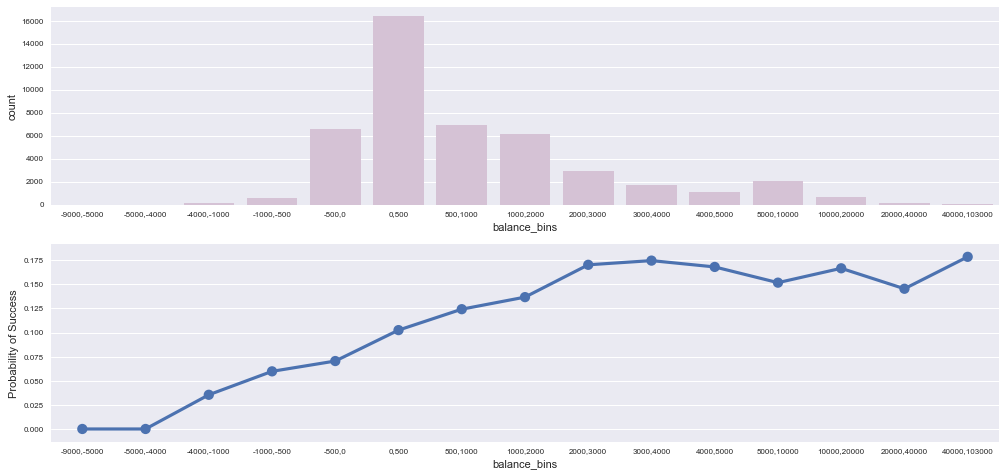

In [85]:
dims = (17, 8)
x_temp, y_temp = get_ratio(data,'balance_bins','y','yes')

f, (ax1, ax2) = plt.subplots(2, figsize = dims)
sns.countplot(data['balance_bins'], color="thistle", ax=ax1)
sns.pointplot(x=x_temp,y=y_temp,ax=ax2,font_scale=45)
ax2.set_ylabel('Probability of Success')
ax2.set_xlabel('balance_bins')
ax1.tick_params(axis='both', which='major', labelsize=8)
ax2.tick_params(axis='both', which='major', labelsize=8)

|-----------------------------------
|    TRAIN - TEST SETS
|-----------------------------------

Minthogy inbalanced output változónk van, ezért kiemelkedően fontos egy kiegyensúlyozott, robosztus test és validation set kialakítása.
Feltételezve, hogy az adatok nem egyetlen évből kerültek összegyújtésre, nincs értelme az utolsó három hónap leválasztani test és validation setnek. Azonban lehetőség nyílik véletlenszerű mintavételre, ahol 70% az adatoknak traning, 30% test felosztást igyekszünk elérni. Fontos, hogy mindegyik halmazban azonos legyen a változók belső eloszlása, tehát ha az egyik halmazunkban 20% az, aki feliratkozott a termékre, akkor a többiben is ilyen arányokat szeretnénk ideális esetben látni.

In [86]:
epsilon = 0.0001
for i in range(1,10000):
    seed = i
    test_size = 0.30
    x_train, x_test= train_test_split(data_w, test_size=test_size, random_state=seed)
    base = data_w[data_w['y']=='yes']['y'].count()/data_w['y'].count()
    t_prop = x_test[x_test['y']=='yes']['y'].count()/x_test['y'].count()
    t_prop = x_train[x_train['y']=='yes']['y'].count()/x_train['y'].count()
    if (abs(base-t_prop) < epsilon) & (abs(base-t_prop) < epsilon):
        print(i)
        break

9


In [87]:
seed = 9
test_size = 0.30
x_train, x_test= train_test_split(data_w, test_size=test_size, random_state=seed)

In [88]:
## get predictors and output for training
y_train = x_train.y_code
x_train = x_train.drop(labels=['y', 'y_code'], axis=1)

In [89]:
x_train.columns

Index(['IDcol', 'age', 'balance', 'day', 'campaign', 'pdays', 'previous',
       'age_bins_code', 'balance_bins_code', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [90]:
## get predictors and output for test
y_test = x_test.y_code
x_test = x_test.drop(labels=['y', 'y_code'], axis=1)
x_test_base = x_test.drop(labels=['age_bins_code','balance_bins_code'], axis=1)

In [91]:
x_train_base = x_train.drop(labels=['age_bins_code','balance_bins_code'], axis=1)
x_train.columns

Index(['IDcol', 'age', 'balance', 'day', 'campaign', 'pdays', 'previous',
       'age_bins_code', 'balance_bins_code', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

|-----------------------------------
|    BASELINE > LOGISTIC REGRESSION
|-----------------------------------

In [92]:
list_to_drop = ['IDcol','age_bins_code','balance_bins_code','month_apr',
                'education_primary','job_technician','housing_no','default_no','loan_no','poutcome_failure']
x_train_reg = x_train.drop(labels=list_to_drop, axis=1)
x_test_reg = x_test.drop(labels=list_to_drop, axis=1)

In [93]:
estimator = LogisticRegression()
rfe = RFE(estimator, 20, step=1)
rfe = rfe.fit(x_train_reg, y_train)

In [94]:
model = LogisticRegression(class_weight='balanced')
model.fit(x_train_reg.loc[:,rfe.support_], y_train)
print(model)
# make predictions
expected = y_test
predicted = model.predict(x_test_reg.loc[:,rfe.support_])
predicted = model.predict_proba(x_test_reg.loc[:,rfe.support_])[:,1]
predicted = pd.DataFrame(predicted)
predicted.columns = ['y_perc']

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [95]:
bins = [0.0,0.62,1.0]
names = [0,1]
predicted['y_code_pred'] = pd.cut(predicted.y_perc, bins, labels=names)

In [96]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted.y_code_pred.values))
print(metrics.confusion_matrix(expected, predicted.y_code_pred.values))

             precision    recall  f1-score   support

          0       0.93      0.92      0.92     11972
          1       0.43      0.45      0.44      1589

avg / total       0.87      0.86      0.87     13561

[[11003   969]
 [  867   722]]


In [97]:
roc_auc_score(expected, predicted.y_code_pred.values)

0.6867174813394039

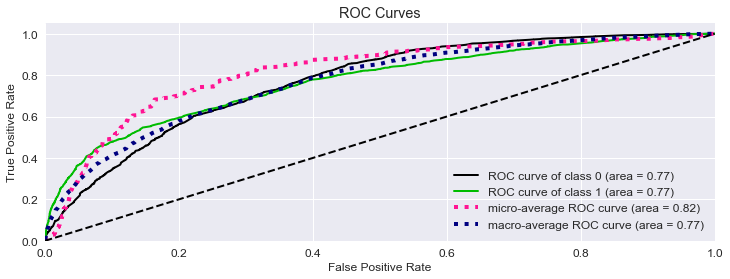

In [98]:
dims = (7, 7)
f, ax1 = plt.subplots(1, figsize = dims)
y_probas = model.predict_proba(x_test_reg.loc[:,rfe.support_])
skplt.metrics.plot_roc(expected, y_probas, ax=ax1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


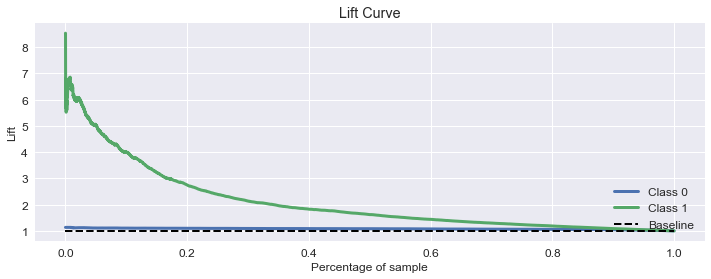

In [99]:
dims = (7, 7)
f, ax1 = plt.subplots(1, figsize = dims)
skplt.metrics.plot_lift_curve(expected, y_probas, ax=ax1)
plt.show()

|-----------------------------------
|    DECISION TREE
|-----------------------------------

In [100]:
seed = 9
test_size = 0.30
data_w.reset_index(inplace=True, drop=True)
x_train, x_test= train_test_split(data_w, test_size=test_size, random_state=seed)

In [101]:
x_train = x_train.drop(labels=['y','age_bins_code','balance_bins_code'], axis=1)
x_test = x_test.drop(labels=['y','age_bins_code','balance_bins_code'], axis=1)

In [102]:
x_test.reset_index(inplace=True, drop=True)

In [103]:
x_train.reset_index(inplace=True, drop=True)
target = 'y_code'
IDcol = 'IDcol'

In [104]:
def grid_search(param_grid, train, features, IDcol, cv_iterations=5, cv_folds=5, nthread=3):
    
    
    pred_return = {}
    for index, params in param_grid.iterrows():
        scores = []
        best_n_estimators = []
        
        pred_all = []
        for cv_index in range(cv_iterations):
            #measure time
            t0= time.clock()
            
            pred = train.loc[:, [IDcol]]
            
            ## find best n_estimators by xgb.cv
            xgb_model = XGBClassifier(
                # Get params from param_grid
                learning_rate = params['learning_rate'],
                max_depth = int(params['max_depth']),
                min_child_weight = params['min_child_weight'],
                gamma = params['gamma'],
                subsample = params['subsample'],
                colsample_bytree = params['colsample_bytree'],
                reg_lambda = params['reg_lambda'],
                reg_alpha = params['reg_alpha'],
                scale_pos_weight = params['scale_pos_weight'],
                n_estimators = params['n_estimators'],

                # Other params
                objective= 'binary:logistic',
                n_jobs = nthread,
                seed = cv_index,
                silent = False
            )

            xgb_train = xgb.DMatrix(train[features].values, label=train[target].values)
            cv_result = xgb.cv(
                xgb_model.get_xgb_params(), 
                xgb_train, 
                num_boost_round = int(params['n_estimators']), 
                nfold = 5,
                metrics = 'auc', 
                early_stopping_rounds = 20)

            best_n_estimator = cv_result.shape[0]
            best_n_estimators.append(best_n_estimator)
            xgb_model.set_params(n_estimators = best_n_estimator)

            ## k-fold cross validation
            skf = StratifiedKFold(n_splits=cv_folds, random_state=cv_index, shuffle=True)
            for train_index, dev_index in skf.split(train[features].values, train[target].values):
                X_train = train[features].iloc[train_index].values
                y_train = train[target].iloc[train_index].values

                X_dev = train[features].iloc[dev_index].values
                y_dev = train[target].iloc[dev_index].values

                # Fit the algorithm on train fold
                xgb_model.fit(X_train, y_train, eval_metric='auc')

                # Predict on dev folds
                pred_dev = xgb_model.predict_proba(X_dev)[:,1]
                pred.at[dev_index, 'Pred'] = pred_dev

                # Compute AUC score
                score = metrics.roc_auc_score(y_dev, pred_dev)            
                scores.append(score)
                
            if(len(pred_all) == 0):
                pred_all = pred
            else:
                pred_all = pd.concat([pred_all, pred], axis = 0)
            
            #measure time
            t= time.clock() - t0 # t is CPU seconds elapsed (floating point)
            print(t)
            
        pred_mean = pred_all.groupby(IDcol)['Pred'].mean() # avg predict_proba for each ID
        score = metrics.roc_auc_score(train.sort_values(IDcol)[target].values, pred_mean) # use avg pred to compute auc score 
        pred_return['Pred_'+str(index)] = pred_mean # store the pred result for use in stacking 
        
        param_grid.at[index, 'n_estimators'] = np.round(np.mean(best_n_estimators))
        param_grid.at[index, 'Score'] = score
        param_grid.at[index, 'Score_Std'] = np.std(scores)
    
    return param_grid, pred_return


In [105]:
## Choose all features except target, IDcols and correlated_features
features = [x for x in x_train.columns if x not in [target, IDcol]]

In [106]:
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

## Potenciális grid serach egy még teljesebb paraméter halmazra


## set paramter grid 1
param_grid_1 = expand_grid({
    # Learning Rate
    'learning_rate': [0.04, 0.05, 0.06],
    
    # Model complexity
    'max_depth': [5, 6],
    'min_child_weight': [0.2, 0.3],
    'gamma': [0.08, 0.1, 0.12],
    
    # Randomness 
    'subsample': [0.85],
    'colsample_bytree': [0.875],
    
    # Regulations
    'reg_lambda': [1, 3],
    'reg_alpha': [3],
    
    # Imbalance
    'scale_pos_weight': [1],
    
    # Other
    'n_estimators' : [1000]
})

param_grid_1, pred_1 = grid_search(
    param_grid=param_grid_1, 
    train=x_train, 
    features=features, 
    IDcol = IDcol,
    cv_iterations=5, 
    cv_folds=5,
    nthread=7)


In [123]:
## applied grid search
## set paramter grid 1
param_grid_1 = expand_grid({
    # Learning Rate
    'learning_rate': [0.05],
    
    # Model complexity
    'max_depth': [5, 6],
    'min_child_weight': [0.2, 0.3],
    'gamma': [0.1],
    
    # Randomness 
    'subsample': [0.85],
    'colsample_bytree': [0.875],
    
    # Regulations
    'reg_lambda': [1,3],
    'reg_alpha': [3],
    
    # Imbalance
    'scale_pos_weight': [1],
    
    # Other
    'n_estimators' : [1000]
})

param_grid_1, pred_1 = grid_search(
    param_grid=param_grid_1, 
    train=x_train, 
    features=features, 
    IDcol = IDcol,
    cv_iterations=5, 
    cv_folds=5,
    nthread=7)

37.01882487890907
44.62495617395052
47.44475002935451
41.23373879100018
44.167258267009856
56.28432698379038
58.951015820074645
65.64266353993025
56.91046184239349
44.1825298489257
43.74687511033517
39.66153768465483
45.77421886995762
47.20007915374481
48.170485588518204
35.88148040493252
46.36012818965355
64.05551149001985
72.34454130651284
56.344294566883036
48.78536033428463
43.552496011521725
47.702912759270475
48.04270237781566
38.03095042791392
42.44056284552789
47.390203738783384
39.19779157768062
43.5068524644812
43.77516641582042
40.734644871470664
46.350909323800806
44.00167175336355
66.27598915495219
59.25488614259302
54.21604661531637
46.98546001545219
47.55121181591312
45.8772312282872
43.314605754412696


In [125]:
def predict_top_params(param_grid, train, test, features, IDcol, nthread=3):
    pred_all = []
    roc_base = []
    for index, params in param_grid.iterrows(): 
        xgb_model = XGBClassifier(
            # Get params from param_grid
            learning_rate = params['learning_rate'],
            max_depth = int(params['max_depth']),
            min_child_weight = params['min_child_weight'],
            gamma = params['gamma'],
            subsample = params['subsample'],
            colsample_bytree = params['colsample_bytree'],
            reg_lambda = params['reg_lambda'],
            reg_alpha = params['reg_alpha'],
            scale_pos_weight = params['scale_pos_weight'],
            n_estimators = int(params['n_estimators']),

            # Other params
            objective= 'binary:logistic',
            n_jobs = nthread,
            seed = index,
            silent = False
        )

        X_train = train[features].values
        y_train = train[target].values

        X_test = test[features].values

        # Fit the algorithm on train data
        xgb_model.fit(X_train, y_train, eval_metric='auc')

        # Predict on test data
        pred = test.loc[:, [IDcol]]
        pred['Pred'] = xgb_model.predict_proba(X_test)[:,1]
        roc_base.append(xgb_model.predict_proba(X_test))

        if(len(pred_all) == 0):
            pred_all = pred
        else:
            pred_all = pd.concat([pred_all, pred], axis = 0)

    pred_mean = pred_all.groupby(IDcol)['Pred'].mean() # avg predict_proba for each ID
    return pred_mean, roc_base

In [127]:
top_n = 10 
weight_sd = 0.8

param_grid_1['Overall_Score'] = param_grid_1['Score'] - weight_sd*param_grid_1['Score_Std']
param_grid_1_top = param_grid_1.sort_values('Overall_Score', ascending=False).head(top_n)

pred_1, roc_plot = predict_top_params(
    param_grid = param_grid_1_top, 
    train = x_train, 
    test = x_test, 
    features = features, 
    IDcol = IDcol,
    nthread=7)

In [128]:
# display set of parameters fro explored best models
param_grid_1_top

,learning_rate,max_depth,min_child_weight,gamma,subsample,colsample_bytree,reg_lambda,reg_alpha,scale_pos_weight,n_estimators,Score,Score_Std,Overall_Score
2,0.05,5,0.3,0.1,0.85,0.875,1,3,1,250,0.799213,0.006678,0.793870
4,0.05,6,0.2,0.1,0.85,0.875,1,3,1,203,0.799284,0.006854,0.793801
5,0.05,6,0.2,0.1,0.85,0.875,3,3,1,201,0.799366,0.006962,0.793797
7,0.05,6,0.3,0.1,0.85,0.875,3,3,1,208,0.799152,0.007159,0.793425
0,0.05,5,0.2,0.1,0.85,0.875,1,3,1,236,0.798991,0.006959,0.793423
6,0.05,6,0.3,0.1,0.85,0.875,1,3,1,202,0.799292,0.007344,0.793417
1,0.05,5,0.2,0.1,0.85,0.875,3,3,1,257,0.798820,0.007036,0.793191
3,0.05,5,0.3,0.1,0.85,0.875,3,3,1,248,0.798738,0.007051,0.793098


In [129]:
pred = pred_1
pred = pd.DataFrame(pred).reset_index()

In [130]:
expected = x_test[['IDcol','y_code']]

In [131]:
result = pd.merge(expected, pred, how='left', on=['IDcol'])

In [132]:
bins = [0.0,0.12,1.0]
names = [0,1]
result['y_code_pred'] = pd.cut(result.Pred, bins, labels=names)

In [133]:
# summarize the fit of the model
print(metrics.classification_report(result.y_code, result.y_code_pred))
print(metrics.confusion_matrix(result.y_code, result.y_code_pred))

             precision    recall  f1-score   support

          0       0.95      0.84      0.89     11972
          1       0.35      0.66      0.46      1589

avg / total       0.88      0.82      0.84     13561

[[10014  1958]
 [  541  1048]]


In [134]:
roc_auc_score(result.y_code, result.y_code_pred)

0.7479930094912042

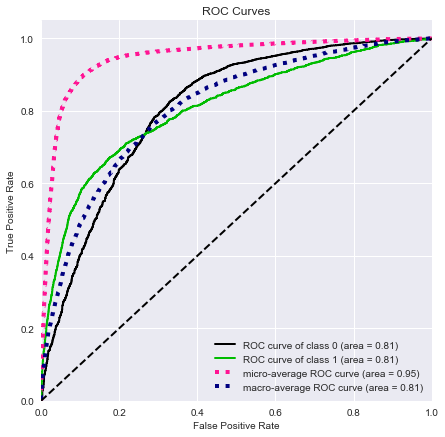

In [146]:
dims = (7, 7)
f, ax1 = plt.subplots(1, figsize = dims)
skplt.metrics.plot_roc(result.y_code, roc_plot[0], ax=ax1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


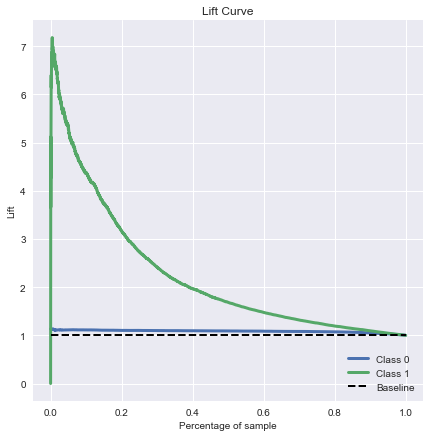

In [143]:
dims = (7, 7)
f, ax1 = plt.subplots(1, figsize = dims)
skplt.metrics.plot_lift_curve(result.y_code, roc_plot[0], ax=ax1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


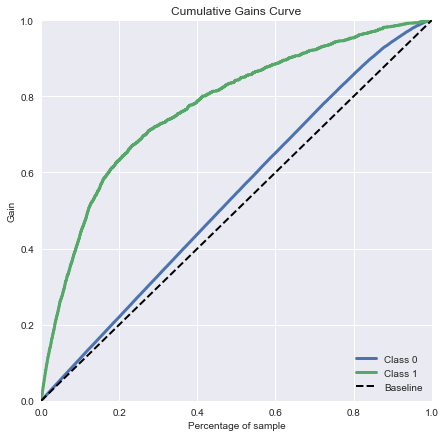

In [142]:
dims = (7, 7)
f, ax1 = plt.subplots(1, figsize = dims)
skplt.metrics.plot_cumulative_gain(result.y_code, roc_plot[0], ax=ax1)
plt.show()